# Explorative Data Analysis, Loading, and Training with ResNet-50 (classification)

In [1]:
# imports, helper functions and globals
from pathlib import Path
from typing import List, Tuple, Optional
import time

import albumentations as A
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from PIL import Image
from torchvision.ops import nms
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm, trange
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import MultilabelAccuracy

def ls(path: Path) -> List[Path]:
    return list(path.iterdir())

ROOT = Path("/kaggle/input/amia-public-challenge-2024")

CLASS_IDS_NAMES = {
    0: 'Aortic enlargement',
    1: 'Atelectasis',
    2: 'Calcification',
    3: 'Cardiomegaly',
    4: 'Consolidation',
    5: 'ILD',
    6: 'Infiltration',
    7: 'Lung Opacity',
    8: 'Nodule/Mass',
    9: 'Other lesion',
    10: 'Pleural effusion',
    11: 'Pleural thickening',
    12: 'Pneumothorax',
    13: 'Pulmonary fibrosis',
    14: 'No finding'
}

2024-05-27 23:08:40.132339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 23:08:40.132409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 23:08:40.134014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Folder structure

In [2]:
ls(ROOT)

[PosixPath('/kaggle/input/amia-public-challenge-2024/sample_submission.csv'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/img_size.csv'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/train.csv'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/test.csv'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/test'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/train')]

In [3]:
# List of train image paths
images = ls(ROOT / "train/train")
images[:2]

[PosixPath('/kaggle/input/amia-public-challenge-2024/train/train/8RftDaYYRcnwhIAfSBzMt8qFQw04pJ4U.png'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/train/train/vi6QVLeiI8G1lVTOl0ATLUmqEMeO4UAv.png')]

In [4]:
# List of test image paths
test_images = ls(ROOT / "train/train")
test_images[:2]

[PosixPath('/kaggle/input/amia-public-challenge-2024/train/train/8RftDaYYRcnwhIAfSBzMt8qFQw04pJ4U.png'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/train/train/vi6QVLeiI8G1lVTOl0ATLUmqEMeO4UAv.png')]

## Explore images

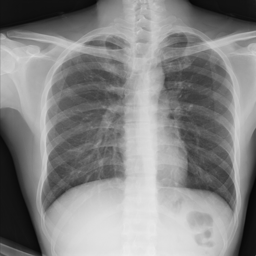

In [5]:
# Reading a single image
Image.open(images[0]).resize((256, 256))

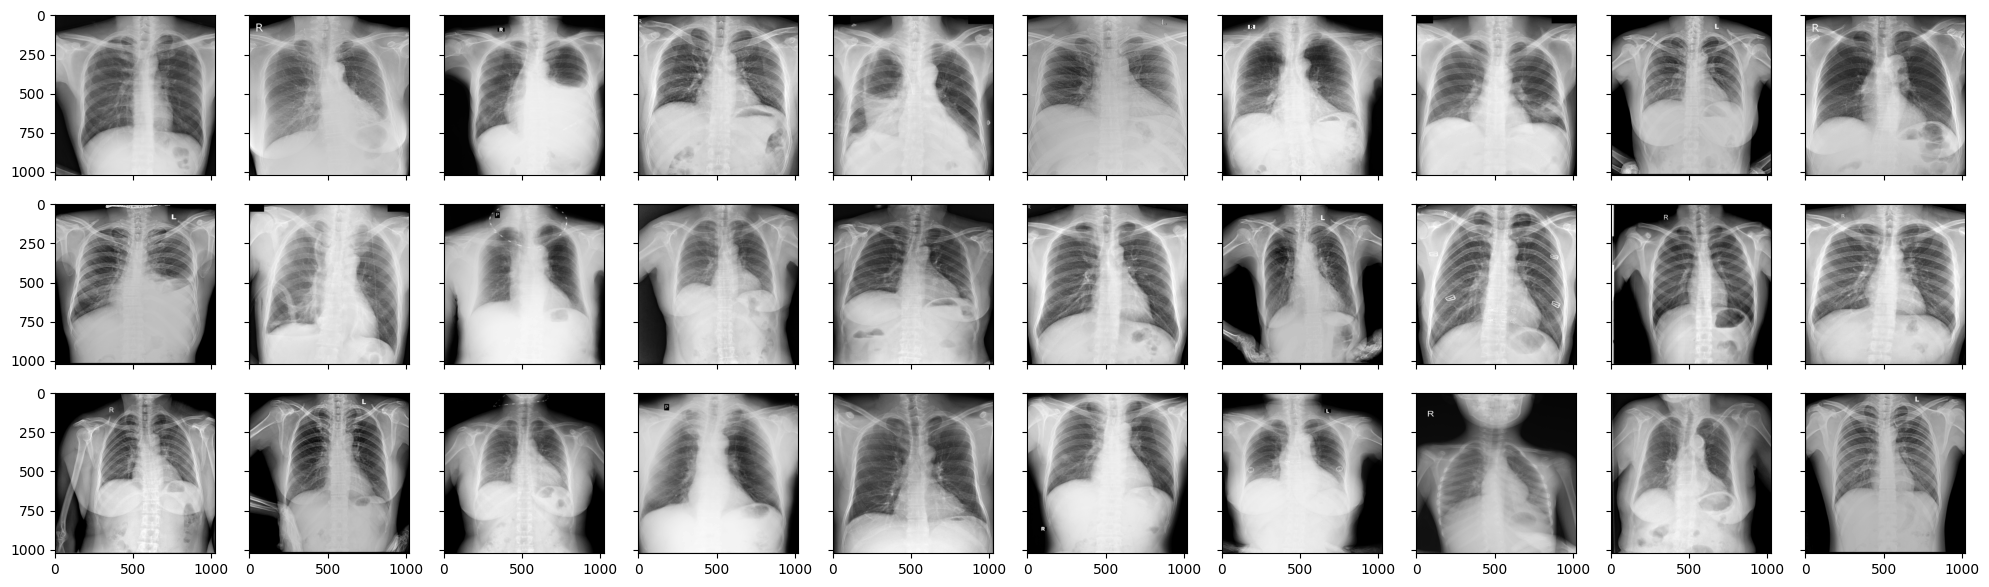

In [6]:
# Some more examples

nrows=3
ncols=10

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True)
fig.set_size_inches(ncols * 2, nrows * 2)
i = 0
for row in range(nrows):
    for col in range(ncols):
        image = np.array(Image.open(images[i]))
        axs[row, col].imshow(image, cmap="gray")
        i += 1

plt.tight_layout()
plt.show()

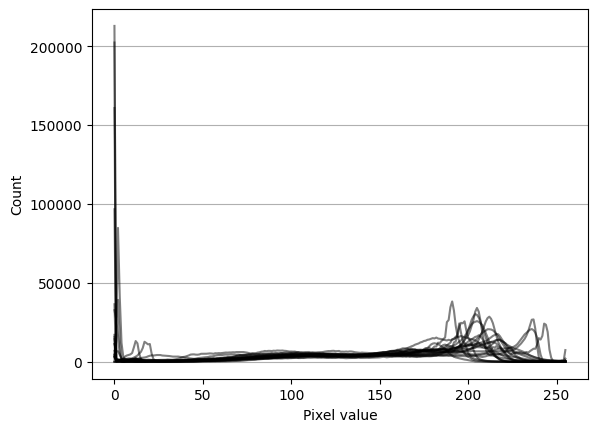

In [7]:
# Lets look at the pixel distributions
for i in range(20):
    pixels = np.array(Image.open(images[i])).flatten()
    count, _ = np.histogram(pixels, bins=256, range=(0, 255))
    plt.plot(count, color="black", alpha=0.5)
    
plt.ylabel("Count")
# plt.yscale("log")
plt.xlabel("Pixel value")
plt.grid(axis="y")
plt.show()

## Bounding Box Annotations

All images are rescaled to have shape (1024x1024). The bounding box coordinates still have to be adapted to this new image shape. image_size.csv contains the original image size and is used here to rescale the boudning box coordinates.  
Check explanations [here](https://www.kaggle.com/competitions/amia-public-challenge-2024/data).

In [8]:
def read_and_proccess_annotations(partition):
    assert partition in ["train", "test"]
    
    # This dataframe contains the original image sizes.
    # They are used to normalize the bounding box coordinates.
    image_sizes = pd.read_csv(ROOT / "img_size.csv")
    image_sizes.rename({"dim0": "original_image_height", "dim1": "original_image_width"},
                       axis=1, inplace=True)
    
    # Read dataframe and merge with image_size information
    df =  pd.read_csv(ROOT / f"{partition}.csv")
    df = df.merge(image_sizes)
    
    # Normalize the bounding box coordinates to the resized images of shape (1024, 1024)
    if partition == "train":
        # Normalize coordinates accoring to height and width of the original images
        df["x_min_norm"] = (df.x_min / df.original_image_width) * 1024
        df["x_max_norm"] = (df.x_max / df.original_image_width) * 1024
        df["y_min_norm"] = (df.y_min / df.original_image_height) * 1024
        df["y_max_norm"] = (df.y_max / df.original_image_height) * 1024


        # Compute the bounding box width and height
        df["width"] = df.x_max_norm - df.x_min_norm 
        df["height"] = df.y_max_norm - df.y_min_norm
    
    return df

In [9]:
train_df = read_and_proccess_annotations("train")
test_df = read_and_proccess_annotations("test")

In [10]:
train_df.head(3)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,original_image_height,original_image_width,x_min_norm,x_max_norm,y_min_norm,y_max_norm,width,height
0,bM8C97htulC9fHKIDurJHquCXr1KZuug,No finding,14,R5,NaN,NaN,NaN,NaN,2430,1994,NaN,NaN,NaN,NaN,NaN,NaN
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Aortic enlargement,0,R10,1148.0,503.0,1466.0,823.0,2154,2402,489.405495,624.972523,239.123491,391.249768,135.567027,152.126277
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w,Consolidation,4,R8,264.0,732.0,550.0,1119.0,2464,2072,130.471042,271.814672,304.207792,465.038961,141.343629,160.831169


In [11]:
test_df.head(3)

,image_id,original_image_height,original_image_width
0,3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c,2880,2304
1,LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm,2430,1994
2,PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W,2430,1994


## Class Annotations

In [12]:
# For every sample we have multiple labels. This is a multi-label classification task!
# Additionally we have labels from multiple radiologists (rad_id). 
# Every entry corresponds to a single bounding box.

train_df[train_df.image_id == "0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m"]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,original_image_height,original_image_width,x_min_norm,x_max_norm,y_min_norm,y_max_norm,width,height
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Aortic enlargement,0,R10,1148.0,503.0,1466.0,823.0,2154,2402,489.405495,624.972523,239.123491,391.249768,135.567027,152.126277
3870,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Cardiomegaly,3,R9,791.0,1285.0,1919.0,1617.0,2154,2402,337.212323,818.091590,610.882080,768.713092,480.879267,157.831012
20371,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Aortic enlargement,0,R8,1173.0,489.0,1460.0,829.0,2154,2402,500.063281,622.414654,232.467967,394.102136,122.351374,161.634169
22991,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Cardiomegaly,3,R8,777.0,1172.0,1911.0,1617.0,2154,2402,331.243963,814.681099,557.162488,768.713092,483.437136,211.550604
25191,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Aortic enlargement,0,R9,1186.0,539.0,1461.0,837.0,2154,2402,505.605329,622.840966,256.237697,397.905292,117.235637,141.667595
30520,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Cardiomegaly,3,R10,789.0,1432.0,1925.0,1703.0,2154,2402,336.359700,820.649459,680.765088,809.597029,484.289759,128.831941


In [13]:
# We have 15 unique classes!
sorted(train_df.class_id.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [14]:
# Mapping of class ids to class names
train_df.groupby("class_id").class_name.first().to_dict()

{0: 'Aortic enlargement',
 1: 'Atelectasis',
 2: 'Calcification',
 3: 'Cardiomegaly',
 4: 'Consolidation',
 5: 'ILD',
 6: 'Infiltration',
 7: 'Lung Opacity',
 8: 'Nodule/Mass',
 9: 'Other lesion',
 10: 'Pleural effusion',
 11: 'Pleural thickening',
 12: 'Pneumothorax',
 13: 'Pulmonary fibrosis',
 14: 'No finding'}

## Exploration

Ideas for classification labels:
- Why are the more counts for some classes then we have samples?
- Do we have class imbalance?
- What is the frequency of every class?
- Can we see classes accuring often together?

Ideas for bounding boxes:
- What are the size of the boxes for different classes?
- Are the boxes equally distributed across the images? Any differences per class?
- How do the outliers look?

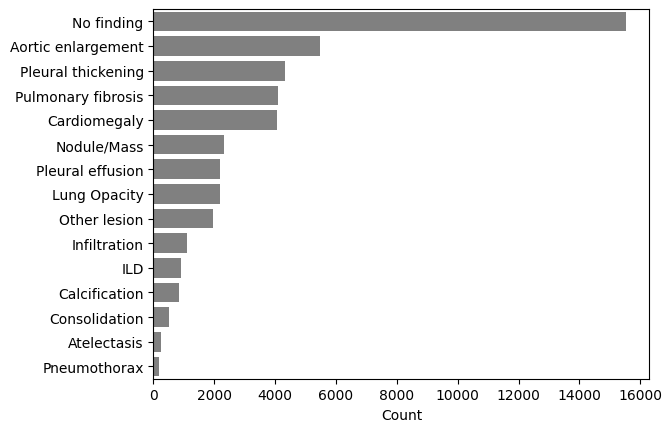

In [15]:
counts = train_df['class_name'].value_counts()

sns.barplot(y=counts.index, x=counts.values, color="gray")
plt.xlabel("Count")
plt.ylabel("")
plt.show()

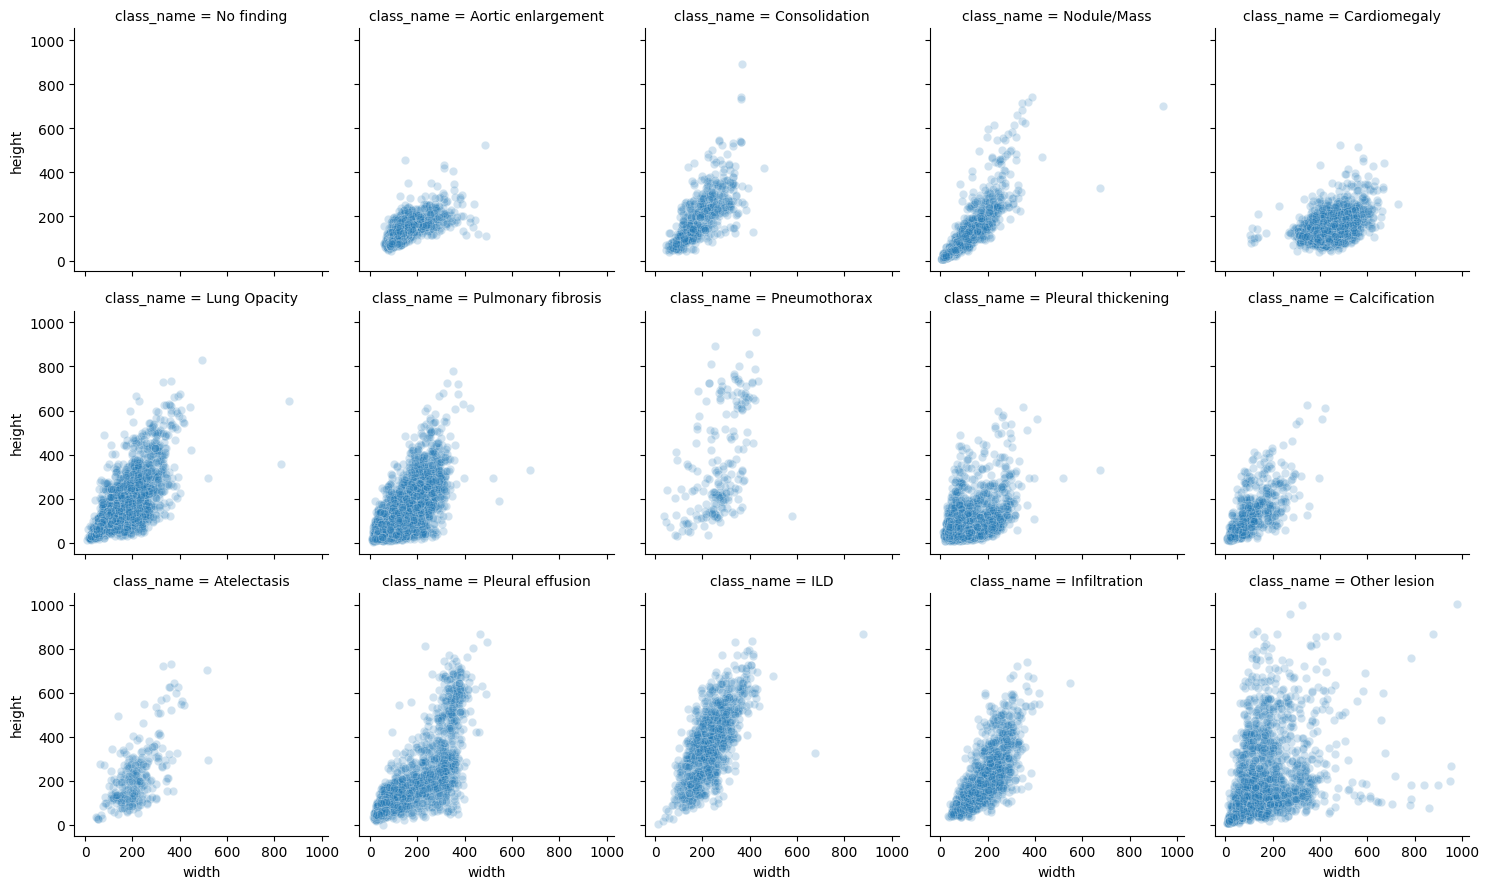

In [16]:
g = sns.FacetGrid(train_df, col="class_name", col_wrap=5)
g.map(sns.scatterplot, "width", "height", alpha=0.2);

## Dataset class

In [17]:
def to_one_hot_encoded(class_indeces, num_classes=15) -> torch.Tensor:
    one_hot_encoded = torch.zeros(num_classes)
    one_hot_encoded[torch.unique(torch.tensor(class_indeces))] = 1.
    return one_hot_encoded

def plot_bounding_boxes(image, bounding_boxes, class_ids=None, ax=None):
    
    if ax is None:
        plt.imshow(image, cmap="gray")
        ax = plt.gca()
    else:
        ax.imshow(image, cmap="gray")
    
    if class_ids is not None:
        colors = [mpl.colormaps["tab20b"](i) for i in class_ids]
    
    for i, bbox in enumerate(bounding_boxes):
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor=colors[i], linewidth=2)
        ax.add_patch(rect)
        if class_ids is not None:
            class_id = class_ids[i]
            ax.text(xmin, ymin - 10, f'{CLASS_IDS_NAMES[class_id]}', bbox=dict(facecolor=colors[i], alpha=0.2), fontsize=12, color='white')
    
    return ax

In [18]:
class AMIADataset:
    def __init__(self, partition="train", iou_threshold=0.7, transform=None):
          
        self.num_classes = 15        
        self.iou_threshold = iou_threshold

        self.data = read_and_proccess_annotations(partition)
        self.images = ls(ROOT / f"{partition}/{partition}")
        
        self.transform = transform
    
    def __len__(self) -> int:
        return len(self.images)
    
    def _read_bounding_box(self, sample: pd.Series) -> Tuple[torch.Tensor, List]:
        """Process bounding boxes for a given sample."""

        bboxes = sample.loc[:, ["x_min_norm", "y_min_norm", "x_max_norm", "y_max_norm"]]
        bboxes = torch.tensor(bboxes.values).float() / 1024 # Normalize to 0 and 1.
        
        # Apply Non-maximum Supression to remove highly overlapping bounding boxes.
        boxes_to_keep = nms(bboxes, torch.ones(len(bboxes)), self.iou_threshold)
        bboxes = bboxes[boxes_to_keep]
        
        return bboxes, boxes_to_keep.tolist()
    
    def __getitem__(self, idx: int) -> Tuple[np.ndarray, List[int], Optional[torch.Tensor]]:
        
        # Get sample by image_id
        image_path = self.images[idx]
        image_id = image_path.stem
        image = np.array(Image.open(image_path))

        sample = self.data[self.data.image_id == image_id]

        # Generate one hot encode target vector
        labels = to_one_hot_encoded(sample.class_id.unique())

        # Generate bounding box list           
        bboxes, boxes_to_keep = self._read_bounding_box(sample)

        # Only keep class labels of kept bounding bobxes
        class_labels = sample.class_id.iloc[boxes_to_keep].tolist()

        has_bbox = torch.isnan(bboxes).sum() == 0

        # Generate fake bbox for transformation
        if not has_bbox:
            bboxes = torch.zeros(bboxes.shape[0], 4)
            bboxes[:, 2:] += 0.1

        if self.transform is not None:
            transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            image = transformed['image']
            bboxes = torch.tensor(transformed['bboxes'])

        # Remove fake bbox
        if not has_bbox:
            bboxes = None

        return image, class_labels, bboxes

We create a simplified version of the above Dataset Class that only returns the one-hot encoded labels.

As bounding boxes have no use currently in classification...

In [19]:
class AMIADatasetOneHot:
    def __init__(self, partition="train", iou_threshold=0.7, transform=None):
          
        self.num_classes = 15        
        self.iou_threshold = iou_threshold

        self.data = read_and_proccess_annotations(partition)
        self.images = ls(ROOT / f"{partition}/{partition}")
        
        self.transform = transform
    
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self, idx: int) -> Tuple[np.ndarray, List[int], Optional[torch.Tensor]]:
        
        # Get sample by image_id
        image_path = self.images[idx]
        image_id = image_path.stem
        image = np.array(Image.open(image_path))

        sample = self.data[self.data.image_id == image_id]

        # Generate one hot encode target vector
        labels = to_one_hot_encoded(sample.class_id.unique())
        
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed['image']
            
        image = torch.unsqueeze(torch.tensor(image), 0) # add channel dim

        return image, labels

In [20]:
dataset = AMIADatasetOneHot(iou_threshold=0.7)
image, ohc_labels = dataset[1]

print(image.size())
print(ohc_labels)

del dataset

torch.Size([1, 1024, 1024])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.])


## Adding augmentations using *albumentation*.
For more info check:
- [Overview of augmentations](https://albumentations.ai/docs/getting_started/transforms_and_targets/)
- [Bounding box tutorial](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/)

In [21]:
train_transforms = A.Compose([
    A.RandomCrop(width=256, height=256), # 900 x 900 leads to OutOfMemoryError
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

train_dataset = AMIADatasetOneHot(transform=train_transforms, iou_threshold=0.7)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)

image, class_ids = train_dataset[1]
print(image.shape)

torch.Size([1, 256, 256])


## Classification training using *ResNet-50*.

In [22]:
num_class = train_dataset.num_classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device)
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1

In [23]:
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

More detailed view

In [24]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We now change the first conv layer to accpet inputs having only 1 channel dim instead of 3, and change the last fully connected layer to the no. of output classes (15 in our case).

In [25]:
model.conv1 = nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding, bias=False)
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

We now freeze these layers

In [26]:
for name, param in model.named_parameters():
    if 'conv1' in name or 'bn1' in name or 'fc' in name:
        param.requires_grad = False

Start Training

Training using: cuda
----------
epoch 1/4
1/133, train_loss: 0.6965, accuracy: 0.4917
10/133, train_loss: 0.6878, accuracy: 0.5406
20/133, train_loss: 0.6804, accuracy: 0.5896
30/133, train_loss: 0.6689, accuracy: 0.6635
40/133, train_loss: 0.6526, accuracy: 0.7469
50/133, train_loss: 0.6410, accuracy: 0.7823
60/133, train_loss: 0.6310, accuracy: 0.8156
70/133, train_loss: 0.6118, accuracy: 0.8417
80/133, train_loss: 0.5969, accuracy: 0.8573
90/133, train_loss: 0.5783, accuracy: 0.8677
100/133, train_loss: 0.5656, accuracy: 0.8615
110/133, train_loss: 0.5534, accuracy: 0.8490
120/133, train_loss: 0.5355, accuracy: 0.8406
130/133, train_loss: 0.5013, accuracy: 0.8854
epoch 1, average loss: 0.6116, average accuracy: 0.7628
----------
epoch 2/4
1/133, train_loss: 0.5023, accuracy: 0.8740
10/133, train_loss: 0.4693, accuracy: 0.8969
20/133, train_loss: 0.4590, accuracy: 0.8740
30/133, train_loss: 0.4479, accuracy: 0.8760
40/133, train_loss: 0.4592, accuracy: 0.8729
50/133, train_loss: 0.41

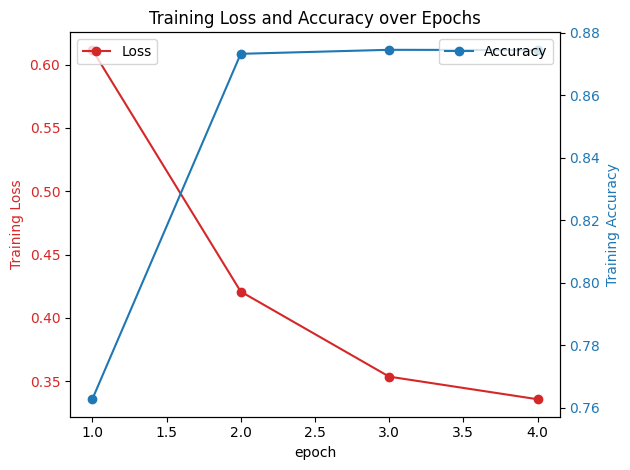

In [27]:
def plott(epoch_loss_values, epoch_acc_values):
    fig, ax1 = plt.subplots()

    epochs = list(range(1, max_epochs + 1))
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('Training Loss', color='tab:red')
    ax1.plot(epochs, epoch_loss_values, color='tab:red', marker='o', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Training Accuracy', color='tab:blue')
    ax2.plot(epochs, epoch_acc_values, color='tab:blue', marker='o', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Training Loss and Accuracy over Epochs')

    fig.tight_layout() 
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

def train(save=False):
    epoch_loss_values = []
    epoch_acc_values = []
    metric_values = []
    writer = SummaryWriter()
    metric = MultilabelAccuracy(num_labels=15).to(device)

    print(f"Training using: {device}")
    start_time = time.time()
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            acc = metric(outputs, labels)
            epoch_acc += acc.item()
            if (step % 10 == 0) or (step == 1):
                print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}, accuracy: {acc.item():.4f}")
            epoch_len = len(train_dataset) // train_loader.batch_size
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        epoch_acc /= step
        epoch_acc_values.append(epoch_acc)
        print(f"epoch {epoch + 1}, average loss: {epoch_loss:.4f}, average accuracy: {epoch_acc:.4f}")

    end_time = time.time()  
    total_time = end_time - start_time
    print(f"Training Completed! Time taken: {total_time/60:.2f} mins\n")
    writer.close()
    
    plott(epoch_loss_values, epoch_acc_values)
    
    if save:
        torch.save(model.state_dict(), "/kaggle/working/trained_resnet50.pth")
    
train()

Unfreeze them and train again


Training using: cuda
----------
epoch 1/4
1/133, train_loss: 0.3874, accuracy: 0.8365
10/133, train_loss: 0.3060, accuracy: 0.8771
20/133, train_loss: 0.3049, accuracy: 0.8844
30/133, train_loss: 0.3720, accuracy: 0.8583
40/133, train_loss: 0.3346, accuracy: 0.8625
50/133, train_loss: 0.3022, accuracy: 0.8896
60/133, train_loss: 0.3190, accuracy: 0.8823
70/133, train_loss: 0.3372, accuracy: 0.8708
80/133, train_loss: 0.3217, accuracy: 0.8740
90/133, train_loss: 0.3456, accuracy: 0.8594
100/133, train_loss: 0.3436, accuracy: 0.8615
110/133, train_loss: 0.3478, accuracy: 0.8552
120/133, train_loss: 0.3731, accuracy: 0.8490
130/133, train_loss: 0.2967, accuracy: 0.8917
epoch 1, average loss: 0.3278, average accuracy: 0.8750
----------
epoch 2/4
1/133, train_loss: 0.3478, accuracy: 0.8552
10/133, train_loss: 0.3009, accuracy: 0.8865
20/133, train_loss: 0.3387, accuracy: 0.8719
30/133, train_loss: 0.2874, accuracy: 0.8979
40/133, train_loss: 0.3428, accuracy: 0.8625
50/133, train_loss: 0.28

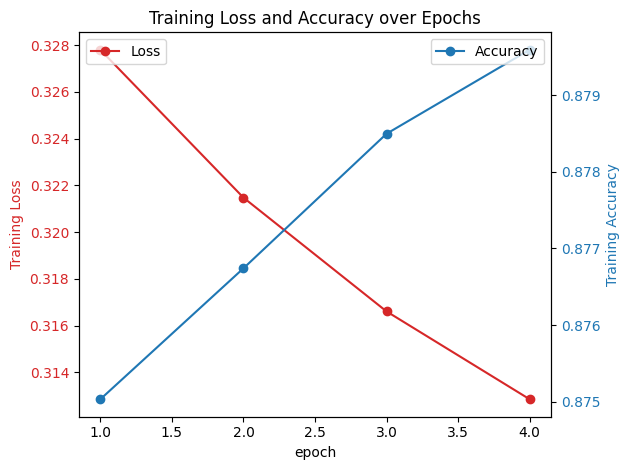

In [28]:
for param in model.parameters():
    param.requires_grad = True
    
train(save=True)